In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe
from matplotlib.ticker import FormatStrFormatter

import corner

import utils

In [2]:
name_A = 'Luhman 16A'; name_B = 'Luhman 16B' # name_A = 'WISE 1049A'; name_B = 'WISE 1049B'
#name_A = 'Luhman 16A'; name_B = 'Luhman 16A (log)'
#color_A = '0.45'; color_B = '0.0'
lw_d = 0.8

#color_m = 'C1'
#color_m_A = 'C0'; color_m_B = 'C3'
#color_m_A = '#FF7B2E'; color_m_B = '#396ED8'
#color_A = '#FF7B2E'; color_B = '#396ED8'
#color_m_A = '#FF4A2E'; color_m_B = '#396ED8'
#color_A = '#FF4A2E'; color_B = '#396ED8'
lw_m = 1.0

In [3]:
Res_A = utils.RetrievalResults(
    prefix='../retrieval_outputs/new_fiducial_K_A_ret_10/test_', 
    m_set='K2166_A', w_set='K2166', load_posterior=True
    )
d_spec_A = Res_A._load_object('d_spec', bestfit_prefix=False)

Res_B = utils.RetrievalResults(
    #prefix='../retrieval_outputs/new_fiducial_K_B_ret_6/test_', 
    prefix='../retrieval_outputs/new_fiducial_K_B_ret_5/test_', 
    m_set='K2166_B', w_set='K2166', load_posterior=True
    #prefix='../retrieval_outputs/new_fiducial_K_A_ret_11/test_', 
    #m_set='K2166_A', w_set='K2166', load_posterior=True
    )
d_spec_B = Res_B._load_object('d_spec', bestfit_prefix=False)

  analysing data from ../retrieval_outputs/new_fiducial_K_A_ret_10/test_.txt
['modes', 'nested sampling global log-evidence', 'nested sampling global log-evidence error', 'global evidence', 'global evidence error', 'nested importance sampling global log-evidence', 'nested importance sampling global log-evidence error', 'marginals']
999842.8530926444
977809.465665599
977809.465665599
  analysing data from ../retrieval_outputs/new_fiducial_K_B_ret_5/test_.txt
['modes', 'nested sampling global log-evidence', 'nested sampling global log-evidence error', 'global evidence', 'global evidence error', 'nested importance sampling global log-evidence', 'nested importance sampling global log-evidence error', 'marginals']
1008102.1030179668
1008072.4699441883
1008072.4699441883


## Observations

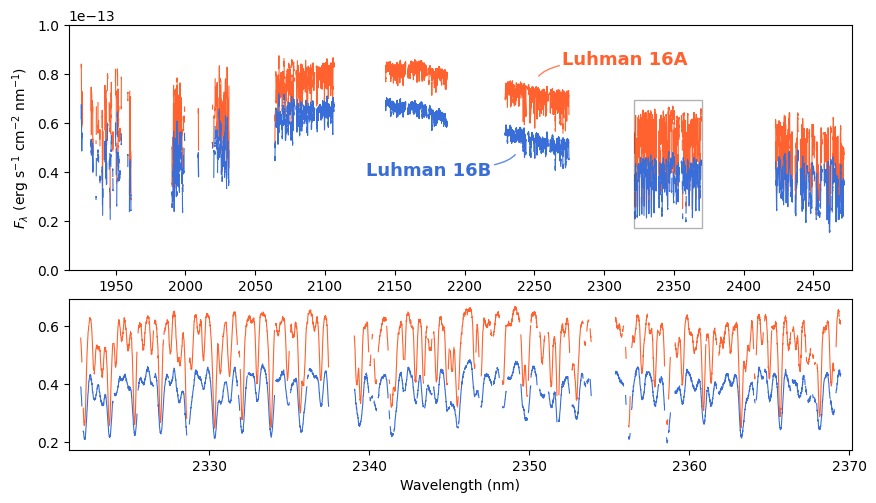

'\nfig, ax = plt.subplots(figsize=(15,4))\n\nfor i in range(d_spec_A.n_orders):\n    for j in range(d_spec_A.n_dets):\n        ax.plot(d_spec_A.wave[i,j], d_spec_A.flux[i,j]/d_spec_A.err[i,j], c=color_m_A)\n        ax.plot(d_spec_B.wave[i,j], d_spec_B.flux[i,j]/d_spec_B.err[i,j], c=color_m_B)\n\nax.set(xlim=(d_spec_A.wave[-2,1].min(), d_spec_A.wave[-2,1].max()))\n#ax.set(xlim=(d_spec_A.wave[3,1].min(), d_spec_A.wave[3,1].max()))\nax.grid(True)\nplt.show()\n'

In [4]:
#color_m_A = '#FF7B2E'; color_m_B = '#396ED8'
#color_A = '#FF7B2E'; color_B = '#396ED8'
color_m_A = '#FF622E'; color_m_B = '#396ED8'
color_A = '#FF622E'; color_B = '#396ED8'

scale = 1e-13
orders_to_plot = [5]

fig = plt.figure(figsize=(9,5))
gs = fig.add_gridspec(
    nrows=2, ncols=1, hspace=0.15, wspace=0, height_ratios=[0.62,(1-0.62)], 
)
ax = np.array([
    fig.add_subplot(gs[0,0]), 
    fig.add_subplot(gs[1,0]), 
])
for i in range(d_spec_B.n_orders):
    for j in range(d_spec_B.n_dets):
        #ax[0].plot(d_spec_B.wave[i,j], d_spec_B.flux_uncorr[i,j]/d_spec_B.transm[i,j], c='k', lw=0.5, alpha=0.3)
        try:
            ax[0].plot(d_spec_A.wave[i,j], d_spec_A.flux[i,j], c=color_A, lw=lw_d)
        except:
            pass

        ax[0].plot(d_spec_B.wave[i,j], d_spec_B.flux[i,j], c=color_B, lw=lw_d)

        if i == orders_to_plot[0]:
            ax[1].plot(d_spec_A.wave[i,j], d_spec_A.flux[i,j]/scale, c=color_A, lw=lw_d)
            ax[1].plot(d_spec_B.wave[i,j], d_spec_B.flux[i,j]/scale, c=color_B, lw=lw_d)
            ax[1].set(
                xlim=(d_spec_A.wave[i,:].min()-0.5,d_spec_A.wave[i,:].max()+0.5)
                )

ax[0].ticklabel_format(axis='y', style='sci', scilimits=(np.log10(scale), np.log10(scale)))
ax[0].set(xticks=np.arange(1900,2500+1,50))
ax[0].set(
    xlim=(d_spec_B.wave.min()-5,d_spec_B.wave.max()+5), ylim=(0,1e-13), 
    ylabel=r'$F_\lambda\ \mathrm{(erg\ s^{-1}\ cm^{-2}\ nm^{-1})}$', 
    )
ax[-1].set(xlabel=r'Wavelength (nm)')

for ax_i in ax[1:]:

    # Plot the inset rectangle(s)
    x0 = ax_i.get_xlim()[0]
    y0 = ax_i.get_ylim()[0]
    width  = np.abs(ax_i.get_xlim()[1] - x0)
    height = np.abs(ax_i.get_ylim()[1] - y0)
    bounds = (x0, y0*scale, width, height*scale)

    _, con_patch = ax[0].indicate_inset(
        bounds=bounds, inset_ax=ax_i, edgecolor='k', alpha=0.3, 
        )
    #for con_patch_j in con_patch:
    #    con_patch_j.set_visible(False)
    [con_patch_j.set_visible(False) for con_patch_j in con_patch]

ax[0].annotate(
    name_A, xy=(0.6,0.79), xytext=(0.63,0.82), xycoords='axes fraction', 
    ha='left', va='bottom', c=color_A, fontsize=13, fontweight='bold',  
    arrowprops={ 
        'arrowstyle':'-', 'connectionstyle':'angle3,angleA=0,angleB=50', 
        'shrinkA':0, 'shrinkB':0, 'lw':1, 'color':color_A, 'alpha':0.8, 
        }, 
    )

ax[0].annotate(
    name_B, xy=(0.57,0.47), xytext=(0.54,0.37), xycoords='axes fraction', 
    ha='right', va='bottom', c=color_B, fontsize=13, fontweight='bold',
    arrowprops={
        'arrowstyle':'-', 'connectionstyle':'angle3,angleA=0,angleB=50',
        'shrinkA':0, 'shrinkB':0, 'lw':1, 'color':color_B, 'alpha':0.8, 
        }, 
    )

plt.subplots_adjust(left=0.09, bottom=0.10, top=0.95, right=0.96)
plt.savefig('./plots/K_band_spectrum.pdf')
plt.show()

'''
fig, ax = plt.subplots(figsize=(15,4))

for i in range(d_spec_A.n_orders):
    for j in range(d_spec_A.n_dets):
        ax.plot(d_spec_A.wave[i,j], d_spec_A.flux[i,j]/d_spec_A.err[i,j], c=color_m_A)
        ax.plot(d_spec_B.wave[i,j], d_spec_B.flux[i,j]/d_spec_B.err[i,j], c=color_m_B)

ax.set(xlim=(d_spec_A.wave[-2,1].min(), d_spec_A.wave[-2,1].max()))
#ax.set(xlim=(d_spec_A.wave[3,1].min(), d_spec_A.wave[3,1].max()))
ax.grid(True)
plt.show()
'''

## Best-fitting model

In [5]:
#color_A = color_B
color_A = '0.0'; color_B = '0.0'
res_alpha = 0.85

LogLike_A = Res_A._load_object('LogLike', bestfit_prefix=True)
LogLike_B = Res_B._load_object('LogLike', bestfit_prefix=True)

sigma_A = Res_A.get_mean_scaled_uncertainty()
sigma_B = Res_B.get_mean_scaled_uncertainty()

for i in range(d_spec_B.n_orders):

    fig = plt.figure(figsize=(9,3.8))
    gs = fig.add_gridspec(
        nrows=4, ncols=1, hspace=0.0, wspace=0, height_ratios=[(0.85-0.02)/2,(0.85-0.02)/2,0.02,0.15], 
    )
    ax = np.array([
        fig.add_subplot(gs[0,0]), 
        fig.add_subplot(gs[1,0]), 
        fig.add_subplot(gs[3,0]), 
    ])
    for j in range(d_spec_B.n_dets):
        ax[0].plot(d_spec_A.wave[i,j], d_spec_A.flux[i,j], c=color_A, lw=lw_d)
        ax[0].plot(d_spec_A.wave[i,j], LogLike_A.m_flux_phi[i,j], c=color_m_A, lw=lw_m)
        
        ax[1].plot(d_spec_B.wave[i,j], d_spec_B.flux[i,j]/scale, c=color_B, lw=lw_d)
        ax[1].plot(d_spec_B.wave[i,j], LogLike_B.m_flux_phi[i,j]/scale, c=color_m_B, lw=lw_m)

        ax[-1].plot(
            d_spec_B.wave[i,j], (d_spec_B.flux[i,j]-LogLike_B.m_flux_phi[i,j])/scale, 
            c=color_m_B, lw=lw_d, alpha=res_alpha
            )
        ax[-1].plot(
            d_spec_A.wave[i,j], (d_spec_A.flux[i,j]-LogLike_A.m_flux_phi[i,j])/scale, 
            c=color_m_A, lw=lw_d, alpha=res_alpha
            )
        
    for j, ax_j in enumerate(ax):

        # Axis limits
        if j != len(ax)-1:
            ax_j.set(xticks=[])
        else:
            ax_j.set(ylim=(-0.022,0.022))
        ax_j.set(xlim=(d_spec_A.wave[i,:].min()-0.5,d_spec_A.wave[i,:].max()+0.6))

        '''
        if j == 0:
            # Share ylim
            ylim0 = np.asarray(ax[0].get_ylim())/scale
            ylim1 = np.asarray(ax[1].get_ylim())

            ylim = np.array([min([ylim0[0], ylim1[0]]), max([ylim0[1], ylim1[1]])])
            ax[0].set(ylim=ylim*scale); ax[1].set(ylim=ylim)
        '''

    # Errorbar
    ax[-1].axhline(0.0, c=color_B, lw=ax[-1].spines['left'].get_lw())
    ax[-1].errorbar(
        d_spec_A.wave[i,:].max()+0.15, 0.0, yerr=sigma_A[i,0]/scale, 
        c=color_m_A, capsize=2, lw=1.5, capthick=1.5
        )
    ax[-1].errorbar(
        d_spec_A.wave[i,:].max()+0.35, 0.0, yerr=sigma_B[i,0]/scale, 
        c=color_m_B, capsize=2, lw=1.5, capthick=1.5
        )

    # Axis ticks
    ax[0].ticklabel_format(axis='y', style='sci', scilimits=(np.log10(scale),np.log10(scale)))

    decimals0 = []
    for label_i in ax[0].get_yticklabels():
        if len(label_i.get_text().rsplit('.')) == 1:
            decimals0.append(0)
        else:
            decimals0.append(len(label_i.get_text().rsplit('.')[1]))

    decimals1 = []
    for label_i in ax[1].get_yticklabels():
        if len(label_i.get_text().rsplit('.')) == 1:
            decimals1.append(0)
        else:
            decimals1.append(len(label_i.get_text().rsplit('.')[1]))

    decimals = max([*decimals0,*decimals1])
    decimals = max([*decimals0])

    ax[1].yaxis.set_major_formatter(FormatStrFormatter(r'$%.'+str(decimals)+'f$'))
    ax[-1].yaxis.set_major_formatter(FormatStrFormatter(r'$%.2f$'))

    ha = 'left'; xy = (0.017,0.05)
    if i in [1,2,5]:
        ha = 'right'; xy = (1-0.017,0.05)
    #if i in [5]:
    #    ha = 'center'; xy = (0.55,0.05)

    # Name labels
    ax[0].annotate(
        name_A, xy=xy, xycoords='axes fraction', 
        ha=ha, va='bottom', c=color_m_A, fontsize=13, fontweight='bold', 
        path_effects=[pe.withStroke(linewidth=2, foreground='w', alpha=0.8)]
        )
    ax[1].annotate(
        name_B, xy=xy, xycoords='axes fraction', 
        ha=ha, va='bottom', c=color_m_B, fontsize=13, fontweight='bold', 
        path_effects=[pe.withStroke(linewidth=2, foreground='w', alpha=0.8)]
        )
    
    # Axis labels
    ax[0].set_ylabel(r'$F_\lambda\ \mathrm{(erg\ s^{-1}\ cm^{-2}\ nm^{-1})}$', y=0)
    ax[-1].set(xlabel=r'Wavelength (nm)', ylabel='Residuals')

    plt.subplots_adjust(left=0.09, bottom=0.12, top=0.94, right=0.98)
    plt.savefig(f'./plots/K_band_spectrum_bestfit_order{i}.pdf')
    #plt.show()
    plt.close()

## Abundance profiles

In [6]:
q = np.array([
    0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 
    0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2
    ])

print(
    '{:.1f} ({:.1f})(+{:.1f})'.format(
        np.median(10**Res_A.posterior[:,7]), 
        *(np.quantile(10**Res_A.posterior[:,7], q=q[[2,4]])-np.median(10**Res_A.posterior[:,7]))
    )
)
print(
    '{:.1f} ({:.1f})(+{:.1f})'.format(
        np.median(10**Res_B.posterior[:,7]), 
        *(np.quantile(10**Res_B.posterior[:,7], q=q[[2,4]])-np.median(10**Res_B.posterior[:,7]))
    )
)

print(
    '{:.0f} ({:.0f})(+{:.0f})'.format(
        np.median(10**Res_B.posterior[:,7]), 
        *(np.quantile(10**Res_B.posterior[:,7], q=q[[2,4]])-np.median(10**Res_B.posterior[:,7]))
    )
)

36.1 (-30.5)(+155.3)
0.0 (-0.0)(+0.0)
0 (-0)(+0)


In [7]:
Chem_A = Res_A._load_object('Chem')
Chem_B = Res_B._load_object('Chem')

PT_A = Res_A._load_object('PT')
PT_B = Res_B._load_object('PT')

contr_A = np.load(f'{Res_A.prefix}data/bestfit_int_contr_em_{Res_A.m_set}.npy')
contr_B = np.load(f'{Res_B.prefix}data/bestfit_int_contr_em_{Res_B.m_set}.npy')

_, opa_envelope_A, _, opa_envelope_A_fine, fine_pressure, _ = Res_A.get_grey_cloud_opacity(
    #keys_indices={'log_opa_base_gray':6, 'log_P_base_gray':7, 'f_sed_gray':8}, 
    keys_indices={'log_opa_base_gray':7, 'log_P_base_gray':8, 'f_sed_gray':9}, 
    )
_, opa_envelope_B, _, opa_envelope_B_fine, fine_pressure, _ = Res_B.get_grey_cloud_opacity(
    #keys_indices={'log_opa_base_gray':6, 'log_P_base_gray':7, 'f_sed_gray':8}, 
    keys_indices={'log_opa_base_gray':7, 'log_P_base_gray':8, 'f_sed_gray':9}, 
    )

In [8]:
VMR_posterior_A = utils.convert_mf_dict_to_VMR_dict(Chem_A, relative_to_key='H2O')
VMR_posterior_B = utils.convert_mf_dict_to_VMR_dict(Chem_B, relative_to_key='H2O')

VMR_envelope_A = {
    species_i: np.quantile(VMR_i, q=q, axis=0) for species_i, VMR_i in VMR_posterior_A.items()
}
VMR_envelope_B = {
    species_i: np.quantile(VMR_i, q=q, axis=0) for species_i, VMR_i in VMR_posterior_B.items()
}

Stoichiometry of species Tc1+ incomplete. Neglected!
Stoichiometry of species Tc1- incomplete. Neglected!
Stoichiometry of species Tc1++ incomplete. Neglected!

FastChem initialisation summary:
  number of species: 938    elements: 80    molecules: 672    condensates: 186



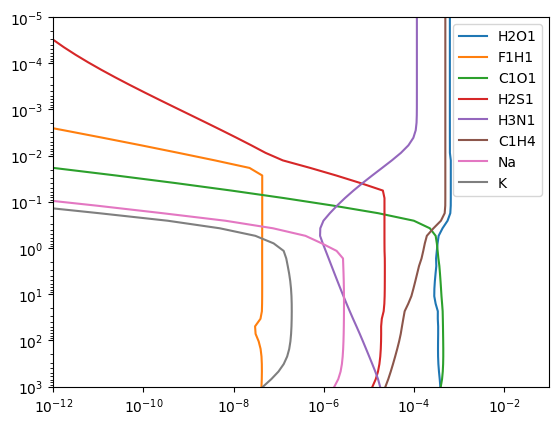

In [37]:
import pyfastchem as pyfc
import os
import petitRADTRANS.nat_cst as nc

class FastChemistry():

    def __init__(self, pressures):

        self.pressures = pressures

        pyfc_path = os.path.dirname(pyfc.__file__)

        self.fastchem = pyfc.FastChem(
            f'{pyfc_path}/input/element_abundances/asplund_2020_extended.dat', 
            f'{pyfc_path}/input/logK/logK_extended.dat',
            f'{pyfc_path}/input/logK/logK_condensates.dat', 
            1)

        # Create in/out-put structures for FastChem
        self.input = pyfc.FastChemInput()
        self.input.pressure = self.pressures[::-1] # Flip to decrease

        self.output = pyfc.FastChemOutput()

        # Use equilibrium condensation
        self.input.equilibrium_condensation = True
        # Use rainout condensation approach
        self.input.rainout_condensation     = True

        # Configure FastChem's internal parameters
        self.fastchem.setParameter('accuracyChem', 1e-5)
        #self.fastchem.setParameter('accuracyElementConservation', 1e-5)
        #self.fastchem.setParameter('accuracyNewton', 1e-5)
        
        self.fastchem.setParameter('nbIterationsChem', 10000)
        #self.fastchem.setParameter('nbIterationsNewton', 10000)
        #self.fastchem.setParameter('nbIterationsNelderMead', 10000)

        # ------------------------------------------------------------------

        # Make a copy of the solar abundances from FastChem
        self.solar_abundances = np.array(self.fastchem.getElementAbundances())

        # Indices of carbon-bearing species
        self.index_C = np.array(self.fastchem.getElementIndex('C'))
        self.index_O = np.array(self.fastchem.getElementIndex('O'))

        # Compute the solar C/O ratio
        self.CO_solar = self.solar_abundances[self.index_C] / \
            self.solar_abundances[self.index_O]

        # Indices of H/He-bearing species
        index_H  = np.array(self.fastchem.getElementIndex('H'))
        index_He = np.array(self.fastchem.getElementIndex('He'))

        self.mask_metal = np.ones_like(self.solar_abundances, dtype=bool)
        self.mask_metal[index_H]  = False
        self.mask_metal[index_He] = False

    def get_VMR(self, species_i):
        index = self.fastchem.getGasSpeciesIndex(species_i)
        return self.VMR[:,index]
    
    def get_condensate_number_density(self, species_i):
        index = self.fastchem.getCondSpeciesIndex(species_i)
        return np.array(self.output.number_densities_cond)[::-1,index]

    def __call__(self, T, CO, FeH):

        temperature = T * np.ones_like(self.pressures)
        temperature[temperature<200] = 200
        self.input.temperature = temperature[::-1] # Flip for FastChem usage

        # Make a copy to modify the elemental abundances
        element_abundances = self.solar_abundances.copy()
        metallicity_wrt_solar = 10**FeH

        # Apply C/O ratio and Fe/H to elemental abundances
        element_abundances[self.index_C] = element_abundances[self.index_O] * CO
        #print(element_abundances[self.index_C] / element_abundances[self.index_O])
        #element_abundances[self.index_C] = element_abundances[self.index_O] * CO
        element_abundances[self.mask_metal] *= metallicity_wrt_solar

        # Update the element abundances
        self.fastchem.setElementAbundances(element_abundances)

        # Compute the number densities
        fastchem_flag = self.fastchem.calcDensities(self.input, self.output)

        if fastchem_flag != 0:
            # FastChem failed to converge
            print('Failed to converge')
        if np.amin(self.output.element_conserved) != 1:
            # Failed element conservation
            print('Failed element conservation')

        # Compute the volume-mixing ratio of all species
        gas_number_density_tot = np.array(self.input.pressure)*1e6 / \
            (nc.kB * np.array(self.input.temperature))
        gas_number_density     = np.array(self.output.number_densities)

        self.VMR = gas_number_density / gas_number_density_tot[:,None]
        self.VMR = self.VMR[::-1] # Flip back

# Compute the chemical equilibrium abundances
FC = FastChemistry(pressures=PT_B.pressure)
FC.input.rainout_condensation = False # Turn rainout off
FC(T=PT_B.temperature, CO=0.59, FeH=0.0)
#FC(T=PT_B.temperature, CO=0.52, FeH=0.2)

#FC(T=PT_B.temperature_envelopes[3], CO=0.59, FeH=0.0)
#FC(T=PT_A.temperature_envelopes[3], CO=0.59, FeH=0.0)


FC_VMR = {
    hill_i: FC.get_VMR(hill_i) for hill_i in ['H2O1', 'F1H1', 'C1O1', 'H2S1', 'H3N1', 'C1H4', 'Na', 'K']
}

for hill_i, VMR_i in FC_VMR.items():
    plt.plot(VMR_i, PT_B.pressure, label=hill_i)

plt.legend()
plt.yscale('log'); plt.xscale('log')
plt.ylim(1e3,1e-5); plt.xlim(1e-12,1e-1)
plt.show()
plt.close()

(1973.8668954730929, 6)
(1697.8346191498345, 1.0)
(1489.1475933273243, 0.05)
(1206.2920014630124, 0.01)


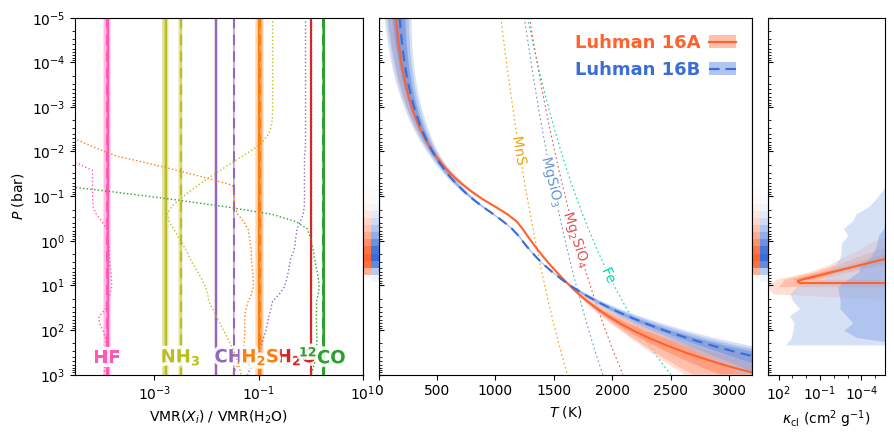

In [38]:
cmap_m_A = mpl.colors.LinearSegmentedColormap.from_list('', ['w',color_m_A])
env_colors_m_A = cmap_m_A([0.4,0.6,0.8])
env_colors_m_A[:,3] = 0.5

cmap_m_B = mpl.colors.LinearSegmentedColormap.from_list('', ['w',color_m_B])
env_colors_m_B = cmap_m_B([0.4,0.6,0.8])
env_colors_m_B[:,3] = 0.5

median_kwargs_A = {'c':color_m_A, 'lw':1.5}
median_kwargs_B = {'c':color_m_B, 'lw':1.5, 'ls':(0,(5,3))}

fig = plt.figure(figsize=(9,4.3))
gs = fig.add_gridspec(
    #nrows=1, ncols=2, hspace=0.0, wspace=0.04, width_ratios=[0.5,0.5], 
    #nrows=1, ncols=3, hspace=0.0, wspace=0.06, width_ratios=[0.37,0.48,0.15], 
    nrows=1, ncols=5, hspace=0.0, wspace=0.0, width_ratios=[0.37,0.02,0.48,0.02,0.15], 
)
ax_VMR = fig.add_subplot(gs[0,0])
ax_PT  = fig.add_subplot(gs[0,2])
ax_cl  = fig.add_subplot(gs[0,4])

ax_contr = np.array([fig.add_subplot(gs[0,1]), fig.add_subplot(gs[0,3])])
for ax_i in ax_contr:
    ax_i.imshow(
        contr_A.reshape(-1,1), cmap=cmap_m_A, aspect='auto', interpolation='none', 
        extent=[0,0.5,0,1], transform=ax_i.transAxes, 
    )
    ax_i.imshow(
        contr_B.reshape(-1,1), cmap=cmap_m_B, aspect='auto', interpolation='none', 
        extent=[0.5,1,0,1], transform=ax_i.transAxes, 
    )
    ax_i.spines[['bottom','top']].set_visible(False)
    ax_i.set(yticks=[], xticks=[])

# --- PT -----------------------------------------------
handle_A = utils.plot_envelopes(
    #ax_PT, PT_A.pressure, x=PT_A.temperature_envelopes, x_indices=[(0,6)], 
    #colors=[env_colors_m_A[0]], median_kwargs=median_kwargs_A, 
    ax_PT, PT_A.pressure, x=PT_A.temperature_envelopes, x_indices=[(0,6),(1,5),(2,4)], 
    colors=[env_colors_m_A[0],env_colors_m_A[1],env_colors_m_A[2]], median_kwargs=median_kwargs_A, 
    )
handle_B = utils.plot_envelopes(
    #ax_PT, PT_B.pressure, x=PT_B.temperature_envelopes, x_indices=[(0,6)], 
    #colors=[env_colors_m_B[0]], median_kwargs=median_kwargs_B, 
    ax_PT, PT_B.pressure, x=PT_B.temperature_envelopes, x_indices=[(0,6),(1,5),(2,4)], 
    colors=[env_colors_m_B[0],env_colors_m_B[1],env_colors_m_B[2]], median_kwargs=median_kwargs_B, 
    )

ax_PT.legend(
    loc='upper right', bbox_to_anchor=(1,1), frameon=False, 
    handles=[handle_A,handle_B], labels=[name_A,name_B], 
    markerfirst=False, handlelength=1.5, handletextpad=0.5, 
    labelcolor='linecolor', prop={'weight':'bold', 'size':13}, 
)

ann_kwargs = dict(
    text='Fe', y=6, clip_on=True, ha='center', va='center', 
    c='#00DBA8', fontsize=10, rotation=-65, #fontweight='bold', 
    path_effects=[pe.withStroke(linewidth=3, foreground='w')],
)
ls = (0,(1.5,2.5)); lw = 0.8
utils.plot_condensation_curve(
    ax_PT, PT_A.pressure, species='Fe', ann_kwargs=ann_kwargs, lw=lw, ls=ls, c=ann_kwargs['c'], 
    )

ann_kwargs['text'] = r'$\mathrm{Mg_2SiO_4}$'
ann_kwargs['y'] = 1.; ann_kwargs['c'] = '#E75252'; ann_kwargs['rotation'] = -72
utils.plot_condensation_curve(
    ax_PT, PT_A.pressure, species='Mg2SiO4', ann_kwargs=ann_kwargs, lw=lw, ls=ls, c=ann_kwargs['c'], 
    )

ann_kwargs['text'] = r'$\mathrm{MgSiO_3}$'
ann_kwargs['y'] = 5e-2; ann_kwargs['c'] = '#6796D6'; ann_kwargs['rotation'] = -76
utils.plot_condensation_curve(
    ax_PT, PT_A.pressure, species='MgSiO3', ann_kwargs=ann_kwargs, lw=lw, ls=ls, c=ann_kwargs['c'], 
    )

ann_kwargs['text'] = r'$\mathrm{MnS}$'
ann_kwargs['y'] = 1e-2; ann_kwargs['c'] = '#F1A208'; ann_kwargs['rotation'] = -80
utils.plot_condensation_curve(
    ax_PT, PT_A.pressure, species='MnS', ann_kwargs=ann_kwargs, lw=lw, ls=ls, c=ann_kwargs['c'], 
    )
'''
ann_kwargs['text'] = r'$\mathrm{Na_2S}$'
ann_kwargs['y'] = 1e2; ann_kwargs['c'] = 'g'; ann_kwargs['rotation'] = -82
utils.plot_condensation_curve(
    ax_PT, PT_A.pressure, species='Na2S', ann_kwargs=ann_kwargs, lw=1, ls=':', c='g', 
    )

ann_kwargs['text'] = r'$\mathrm{KCl}$'
ann_kwargs['y'] = 1e2; ann_kwargs['c'] = 'g'; ann_kwargs['rotation'] = -82
utils.plot_condensation_curve(
    ax_PT, PT_A.pressure, species='KCl', ann_kwargs=ann_kwargs, lw=1, ls=':', c='g', 
    )
'''

ax_PT.tick_params(axis='y', which='both', direction='in')

ax_PT.set(
    yscale='log', ylim=(1e3,1e-5), yticklabels=[], 
    xlim=(0,3200), xlabel=r'$T\ (\mathrm{K})$', xticks=np.arange(0,3500,500), 
    )

# --- Clouds -------------------------------------------
utils.plot_envelopes(
    #ax_cl, PT_A.pressure, x=opa_envelope_A, x_indices=[(0,6)], colors=[env_colors_m_A[0]], 
    ax_cl, PT_A.pressure, x=opa_envelope_A, colors=env_colors_m_A, 
    )
utils.plot_envelopes(
    ax_cl, fine_pressure, x=opa_envelope_A_fine, x_indices=[], 
    colors=[env_colors_m_A[0]], median_kwargs=median_kwargs_A
    )

utils.plot_envelopes(
    #ax_cl, PT_B.pressure, x=opa_envelope_B, x_indices=[(0,6)], colors=[env_colors_m_B[0]], 
    ax_cl, PT_B.pressure, x=opa_envelope_B, colors=env_colors_m_B, 
    )
utils.plot_envelopes(
    ax_cl, fine_pressure, x=opa_envelope_B_fine, x_indices=[], 
    colors=[env_colors_m_B[0]], median_kwargs=median_kwargs_B
    )

ax_cl.tick_params(axis='y', which='both', direction='in')

ax_cl.set(
    yscale='log', ylim=(1e3,1e-5), yticklabels=[], 
    xscale='log', xticks=10.**np.array([2,-1,-4]), xlim=(6e2,2e-6), 
    #xlim=(6e2,2e-20), 
    xlabel=r'$\kappa_\mathrm{cl}\ (\mathrm{cm^2\ g^{-1}})$'
    )
ax_cl.set_xticks([1e1,1e0,1e-2,1e-3,1e-5], labels=[], minor=True)

# --- VMR ----------------------------------------------
#color_species = {'HF':'#FF59B4', '12CO':'C2', 'H2O':'C3', 'NH3':'C8', 'CH4':'C4', 'H2S':'C1'}
#pos_x_species = {'HF':0.0, '12CO':0.0, 'H2O':-0.26, 'NH3':0.0, 'CH4':0.0, 'H2S':0.0}
color_species = {'HF':'#FF59B4', '12CO':'C2', 'H2O':'C3', 'NH3':'C8', 'CH4':'C4', 'H2S':'C1', 'Na':'C1', 'K':'C0'}
pos_x_species = {'HF':0.0, '12CO':0.0, 'H2O':-0.26, 'NH3':0.0, 'CH4':0.0, 'H2S':0.0, 'Na':0.0, 'K':0.0}

#for species_i, hill_i in zip(['H2O','HF','FeH','K','Na'], ['H2O1','F1H1','Fe1H1','K','Na']):
for species_i, hill_i in zip(['H2O','HF','12CO','CH4','NH3','H2S'], ['H2O1','F1H1','C1O1','C1H4','H3N1','H2S1']):
#for species_i, hill_i in zip(['H2O','HF','12CO','CH4','NH3','H2S','Na','K'], ['H2O1','F1H1','C1O1','C1H4','H3N1','H2S1','Na','K']):

    color_i = color_species.get(species_i, 'k')
    cmap = mpl.colors.LinearSegmentedColormap.from_list('', ['w',color_i])
    env_colors_i = cmap([0.4,0.6,0.8])
    env_colors_i[:,3] = 0.5
    
    median_kwargs_A['c'] = color_i
    median_kwargs_B['c'] = color_i

    ax_VMR.plot(FC_VMR[hill_i]/FC_VMR['H2O1'], PT_B.pressure, c=color_i, lw=1, ls=':')

    utils.plot_envelopes(
        #ax_VMR, PT_A.pressure, x=VMR_envelope_A[species_i], x_indices=[(0,6)], 
        #colors=[env_colors_i[0]], median_kwargs=median_kwargs_A
        ax_VMR, PT_A.pressure, x=VMR_envelope_A[species_i], x_indices=[(0,6),(1,5),(2,4)], 
        colors=[env_colors_i[0],env_colors_i[1],env_colors_i[2]], median_kwargs=median_kwargs_A
        )
    try:    
        utils.plot_envelopes(
            #ax_VMR, PT_B.pressure, x=VMR_envelope_B[species_i], x_indices=[(0,6)], 
            #colors=[env_colors_i[0]], median_kwargs=median_kwargs_B
            ax_VMR, PT_B.pressure, x=VMR_envelope_B[species_i], x_indices=[(0,6),(1,5),(2,4)], 
            colors=[env_colors_i[0],env_colors_i[1],env_colors_i[2]], median_kwargs=median_kwargs_B
            )
    except KeyError:
        continue

    pos_x_i = pos_x_species.get(species_i, -0.2)
    
    ha = 'center'
    if pos_x_i > 0:
        ha = 'left'
    elif pos_x_i < 0:
        ha = 'right'

    pos_x_i += np.log10(VMR_envelope_B[species_i][3].max())
    pos_x_i = 10**pos_x_i

    if species_i == 'H2O':
        ha = 'center'; species_i = r'$\mathrm{\bf H_2O}$'
    if species_i == '12CO':
        ha = 'center'; species_i = r'$\mathrm{\bf ^{12}CO}$'
    if species_i == 'CH4':
        ha = 'center'; species_i = r'$\mathrm{\bf CH_4}$'
    if species_i == 'NH3':
        ha = 'center'; species_i = r'$\mathrm{\bf NH_3}$'
    if species_i == 'H2S':
        ha = 'center'; species_i = r'$\mathrm{\bf H_2S}$'

    ax_VMR.annotate(
        species_i, xy=(pos_x_i, 0.02), xycoords=ax_VMR.get_xaxis_transform(), zorder=2, 
        clip_on=True, ha=ha, va='bottom', c=color_i, fontsize=13, fontweight='bold', 
        path_effects=[pe.withStroke(linewidth=5, foreground='w', alpha=0.9)],
    )
    
ax_VMR.set(
    yscale='log', ylim=(1e3,1e-5), ylabel=r'$P\ (\mathrm{bar})$', 
    xscale='log', xlim=(3e-5,1e1), xlabel=r'VMR($X_i$) / VMR($\mathrm{H_2O}$)'
    )
#ax_VMR.set_xticks([1e-6,1e-4,1e-2,1e0], labels=[], minor=True)

plt.subplots_adjust(left=0.08, bottom=0.13, top=0.96, right=0.98)
plt.savefig(f'./plots/K_band_VMR_PT_cl_profiles.pdf')
plt.show()

## Chemical ratios

In [11]:
def get_chem_ratios(VMR):
    
    chem_ratios = {}
    #chem_ratios['C/O'] = VMR['12CO'] / (VMR['12CO']+VMR['H2O'])
    chem_ratios['C/O'] = (VMR['12CO']+VMR['CH4']) / (VMR['12CO']+VMR['H2O'])
    chem_ratios['12CO/13CO'] = VMR['12CO'] / VMR['13CO']
    chem_ratios['C16O/C18O'] = VMR['12CO'] / VMR['C18O']
    chem_ratios['H2(16)O/H2(18)O'] = VMR['H2O'] / VMR['H2(18)O']

    return chem_ratios

VMR_posterior_A = utils.convert_mf_dict_to_VMR_dict(Chem_A, relative_to_key=None)
VMR_posterior_B = utils.convert_mf_dict_to_VMR_dict(Chem_B, relative_to_key=None)

chem_ratios_A = get_chem_ratios(VMR_posterior_A)
chem_ratios_B = get_chem_ratios(VMR_posterior_B)

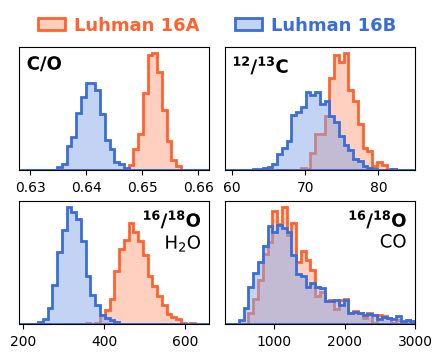

In [90]:
fig = plt.figure(figsize=(4.5,3.6))
gs = fig.add_gridspec(
    nrows=2, ncols=2, hspace=0.25, wspace=0.08, 
)
ax_CO = fig.add_subplot(gs[0,0])
ax_13C = fig.add_subplot(gs[0,1])
ax_18O = fig.add_subplot(gs[1,0])
ax_C18O = fig.add_subplot(gs[1,1], zorder=-1)

hist_kwargs_A = dict(
    #bins=25, histtype='stepfilled', fc=env_colors_m_A[1], ec=color_m_A, lw=2, bottom=0, density=True
    bins=40, histtype='stepfilled', fc=env_colors_m_A[1], ec=color_m_A, lw=2, bottom=0, density=True
)

hist_kwargs_B = hist_kwargs_A.copy()
hist_kwargs_B['fc'] = env_colors_m_B[1]
hist_kwargs_B['ec'] = color_m_B

hist_range = [0.628,0.662]
handle_A = ax_CO.hist(chem_ratios_A['C/O'][:,0], label=name_A, range=hist_range, **hist_kwargs_A)
handle_B = ax_CO.hist(chem_ratios_B['C/O'][:,0], label=name_B, range=hist_range, **hist_kwargs_B)
ax_CO.set(xlim=hist_range)

hist_range = [59,85]
ax_13C.hist(chem_ratios_A['12CO/13CO'][:,0], range=hist_range, **hist_kwargs_A)
ax_13C.hist(chem_ratios_B['12CO/13CO'][:,0], range=hist_range, **hist_kwargs_B)
ax_13C.set(xlim=hist_range)

hist_range = [190,660]
ax_18O.hist(chem_ratios_A['H2(16)O/H2(18)O'][:,0], range=hist_range, **hist_kwargs_A)
ax_18O.hist(chem_ratios_B['H2(16)O/H2(18)O'][:,0], range=hist_range, **hist_kwargs_B)
ax_18O.set(xlim=hist_range)

hist_range = [300,3000]
ax_C18O.hist(chem_ratios_A['C16O/C18O'][:,0], range=hist_range, **hist_kwargs_A)
ax_C18O.hist(chem_ratios_B['C16O/C18O'][:,0], range=hist_range, **hist_kwargs_B)
ax_C18O.set(xlim=hist_range)

iterables = zip(
    [ax_CO, ax_13C, ax_18O, ax_C18O], 
    [
     r'$\mathrm{\bf C/O}$', r'$\mathrm{\bf ^{12}/^{13}C}$', 
     r'$\mathrm{\bf ^{16}/^{18}O}$'+'\n'+r'$\mathrm{H_2O}$', 
     r'$\mathrm{\bf ^{16}/^{18}O}$'+'\n'+r'$\mathrm{CO}$', 
     ]
    )
for i, (ax_i, label_i) in enumerate(iterables):

    ha = 'left'; xy = (0.04,0.93)
    if i >= 2:
        ha = 'right'; xy = (0.96,0.93)

    try:
        ax_i.set_yticks([])
        ax_i.annotate(
            label_i, xy=xy, ha=ha, va='top', xycoords='axes fraction', fontsize=13, 
            path_effects=[pe.withStroke(linewidth=3, foreground='w', alpha=0.9)],
            )
    except:
        pass

ax_CO.legend(
    loc='center', bbox_to_anchor=(0.5,0.93), bbox_transform=fig.transFigure, 
    handlelength=1.5, handletextpad=0.5, ncols=2, frameon=False, 
    labelcolor=[color_m_A, color_m_B], prop={'weight':'bold', 'size':13}, 
)

'''
ax_18O.annotate(
    name_A, xy=(1.1,0.95), xycoords='axes fraction', 
    ha='left', va='top', c=color_m_A, 
    fontsize=13, fontweight='bold', 
    )
ax_18O.annotate(
    name_B, xy=(1.1,0.8), xycoords='axes fraction', 
    ha='left', va='top', c=color_m_B, 
    fontsize=13, fontweight='bold', 
    )
'''
plt.subplots_adjust(left=0.06, bottom=0.1, top=0.87, right=0.94)
plt.savefig(f'./plots/K_band_chem_ratios.pdf')

plt.show()

In [46]:
def get_absolute_abundances(VMR):

    solar = {
        'C': 10**8.46, 
        'N': 10**7.83, 
        'O': 10**8.69, 
        'F': 10**4.40, 
        'S': 10**7.12, 

        'H': 10**12.0, 
    }

    VMR_H = VMR['H2']*2 + VMR['H2O']*2 + VMR['CH4']*4 + VMR['NH3']*3 + VMR['H2S']*2 + VMR['HF']*1
    
    VMR_C = VMR['12CO'] + VMR['CH4']
    VMR_N = VMR['NH3']
    VMR_O = VMR['H2O'] + VMR['12CO'] + VMR['13CO']
    VMR_F = VMR['HF']
    VMR_S = VMR['H2S']

    abs_abund = {
        'C/H': np.log10(VMR_C/VMR_H) - np.log10(solar['C']/solar['H']), 
        'N/H': np.log10(VMR_N/VMR_H) - np.log10(solar['N']/solar['H']), 
        'O/H': np.log10(VMR_O/VMR_H) - np.log10(solar['O']/solar['H']), 
        'F/H': np.log10(VMR_F/VMR_H) - np.log10(solar['F']/solar['H']), 
        'S/H': np.log10(VMR_S/VMR_H) - np.log10(solar['S']/solar['H']), 

        '(C+O)/H': np.log10((VMR_C+VMR_O)/VMR_H) - np.log10((solar['C']+solar['O'])/solar['H']), 

        #'M/H': np.log10((VMR_C+VMR_N+VMR_O+VMR_F+VMR_S)/VMR_H) - \
        #    np.log10((10**8.46+10**7.83+10**8.69+10**4.40+10**7.12)/10**12.0), 
    }
    return abs_abund

abs_abund_A = get_absolute_abundances(VMR_posterior_A)
_ = [print('[{}]: {:.3f} +/- {:.3f}'.format(key_i, np.median(val_i), np.std(val_i))) for key_i, val_i in abs_abund_A.items()]
print()

abs_abund_B = get_absolute_abundances(VMR_posterior_B)
_ = [print('[{}]: {:.3f} +/- {:.3f}'.format(key_i, np.median(val_i), np.std(val_i))) for key_i, val_i in abs_abund_B.items()]

[C/H]: 0.192 +/- 0.005
[N/H]: -2.228 +/- 0.027
[O/H]: 0.151 +/- 0.005
[F/H]: 0.110 +/- 0.017
[S/H]: 0.273 +/- 0.021
[(C+O)/H]: 0.167 +/- 0.005

[C/H]: 0.157 +/- 0.007
[N/H]: -1.942 +/- 0.018
[O/H]: 0.124 +/- 0.006
[F/H]: 0.069 +/- 0.023
[S/H]: 0.295 +/- 0.026
[(C+O)/H]: 0.136 +/- 0.006


In [14]:
def get_log_g_posterior(M_p, R_p):
    G = 6.6743e-8 # cm^3 g^-1 s^-2
    M_p = M_p.copy() * 1.899e30 # g
    R_p = R_p.copy() * 7.149e9 # cm

    g = G*M_p/R_p**2
    return np.log10(g)

log_g_A = get_log_g_posterior(M_p=Res_A.posterior[:,2], R_p=Res_A.posterior[:,3])
log_g_B = get_log_g_posterior(M_p=Res_B.posterior[:,2], R_p=Res_B.posterior[:,3])
#log_g_A = get_log_g_posterior(M_p=Res_A.posterior[:,2], R_p=np.array([1.0]))
#log_g_B = get_log_g_posterior(M_p=Res_B.posterior[:,2], R_p=np.array([1.0]))
#log_g_A = Res_A.posterior[:,2]
#log_g_B = Res_B.posterior[:,2]

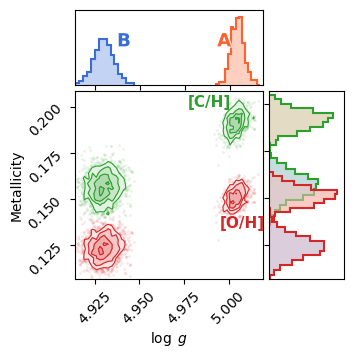

In [50]:
#posterior_ranges = [(4.975,5.02),(0.12,0.21)]; bins = 35
#posterior_ranges = [(4.902,5.02),(0.10,0.205)]; bins = 50
posterior_ranges = [(4.6,5.0),(0.,0.16)]; bins = 15
#labels = [r'$\log\ g$', r'$[\mathrm{C/H}]$ or $[\mathrm{O/H}]$']
labels = [r'$\log\ g$', r'Metallicity']

corner_kwargs = dict(
    bins=bins, 
    #range=posterior_ranges, 
    
    fill_contours=True, 
    plot_datapoints=True, 
    
    labels=labels, 
    #show_titles=True, 
    use_math_text=True, 
    title_fmt='.2f', 
    title_kwargs={'fontsize':10},#, 'loc':'left', 'x':0.05}, 
    #labelpad=0.03, 
    labelpad=-0.03, 
    
    #smooth=True, 
)

fig = plt.figure(figsize=(3.5,3.5))
for key, color_i in zip(['C/H', 'O/H'], [color_species['12CO'], color_species['H2O']]):
#for key, color_i in zip(['C/H', 'O/H', '(C+O)/H'], [color_species['12CO'], color_species['H2O'], 'k']):

    cmap = mpl.colors.LinearSegmentedColormap.from_list('', ['w',color_i])
    env_colors = cmap([0,1/4,2/4,3/4,1])
    env_colors[:,3] = 0.5; env_colors[0,3] = 0.0

    corner_kwargs['color'] = color_i
    corner_kwargs['hist_kwargs'] = {
        'edgecolor':color_i, 'facecolor':env_colors[1], 'fill':True, 'density':True, 'lw':1.5, 
        }
    corner_kwargs['contourf_kwargs'] = {'colors':env_colors}
    corner_kwargs['contour_kwargs']  = {'linewidths':0.8, 'colors':color_i}

    fig = corner.corner(
        fig=fig, 
        data=np.array([log_g_A,abs_abund_A[key][:,0]]).T, 
        **corner_kwargs
    )
    fig = corner.corner(
        fig=fig, 
        data=np.array([log_g_B,abs_abund_B[key][:,0]]).T, 
        **corner_kwargs
    )

# Reshape the axes to a square matrix
ax = np.array(fig.axes)
ax = ax.reshape((int(np.sqrt(len(ax))), int(np.sqrt(len(ax)))))

q = np.array([
    0.5-0.997/2, 0.5-0.95/2, 0.5-0.68/2, 0.5, 
    0.5+0.68/2, 0.5+0.95/2, 0.5+0.997/2
    ])

ann_kwargs = dict(
    xycoords=ax[0,0].get_xaxis_transform(), 
    ha='center', va='top', c=color_m_A, fontsize=13, fontweight='bold', 
    path_effects=[pe.withStroke(linewidth=2, foreground='w', alpha=0.8)]
)
ax[0,0].annotate(
    'A', xy=(np.median(log_g_A)-2*np.std(log_g_A),0.7), **ann_kwargs
    )
ann_kwargs['c'] = color_m_B
ax[0,0].annotate(
    'B', xy=(np.median(log_g_B)+2*np.std(log_g_B),0.7), **ann_kwargs
    )

for i, patch_i in enumerate(list(ax[0,0].patches)):
    patch_i.set_facecolor('none')
    patch_i.set_edgecolor('none')
    if i == 0:
        patch_i.set_facecolor(env_colors_m_A[1])
        patch_i.set_edgecolor(color_m_A)
    elif i == 1:
        patch_i.set_facecolor(env_colors_m_B[1])
        patch_i.set_edgecolor(color_m_B)

# Rotate the axis and apply height/width ratios
for i, patch_i in enumerate(list(ax[1,1].patches)):
    patch_i.set_xy(np.array([patch_i.xy[:,1],patch_i.xy[:,0]]).T)

xlim, ylim = ax[1,1].get_xlim(), ax[1,1].get_ylim()
ax[1,1].set(yticks=ax[1,1].get_xticks(), xticks=ax[1,1].get_yticks())
ax[1,1].set(ylim=xlim, xlim=ylim, xlabel=None)


hist_kwargs = corner_kwargs['hist_kwargs']
hist_kwargs['zorder'] = -1

hist_kwargs['edgecolor'] = 'none'
hist_kwargs['facecolor'] = env_colors_m_A[1]
ax[1,1].hist(abs_abund_A['C/H'][:,0], bins=bins, orientation='horizontal', **hist_kwargs)
ax[1,1].hist(abs_abund_A['O/H'][:,0], bins=bins, orientation='horizontal', **hist_kwargs)

hist_kwargs['facecolor'] = env_colors_m_B[1]
ax[1,1].hist(abs_abund_B['C/H'][:,0], bins=bins, orientation='horizontal', **hist_kwargs)
ax[1,1].hist(abs_abund_B['O/H'][:,0], bins=bins, orientation='horizontal', **hist_kwargs)

xy_CH = (
    np.median(log_g_A)-4*np.std(log_g_A), 
    np.median(abs_abund_A['C/H'][:,0])+2*np.std(abs_abund_A['C/H'][:,0]), 
)
xy_OH = (
    np.median(log_g_A)+1*np.std(log_g_A), 
    np.median(abs_abund_A['O/H'][:,0])-3*np.std(abs_abund_A['O/H'][:,0]), 
)
iterables = zip(
    (xy_CH,xy_OH), (color_species['12CO'],color_species['H2O']), ('[C/H]','[O/H]')
    )

for xy_i, color_i, label_i in iterables:
    ax[1,0].annotate(
        label_i, xy=xy_i, color=color_i, ha='center', va='center', 
        fontsize=11, fontweight='bold'
        )

gs = ax[0,0].get_gridspec()
gs.set_height_ratios([1,2.5]); gs.set_width_ratios([2.5,1], )
gs.update()

plt.subplots_adjust(left=0.2, bottom=0.2, right=0.97, top=0.97)
#plt.savefig('./plots/K_band_log_g_metallicity_R=1.pdf')
plt.show()

In [35]:
print('{:.1e}'.format(np.quantile((VMR_posterior_A['Na'] / VMR_posterior_A['H2O'])[:,0], q=q)[-2]))
print('{:.1e}'.format(np.quantile((VMR_posterior_A['K'] / VMR_posterior_A['H2O'])[:,0], q=q)[-2]))

1.8e-01
6.2e-02


In [16]:
from scipy.stats import pearsonr

print(
    pearsonr(log_g_A, abs_abund_A['C/H'][:,0]), 
    pearsonr(log_g_B, abs_abund_B['C/H'][:,0])
)

PearsonRResult(statistic=0.3653571129981715, pvalue=1.1787492922574443e-31) PearsonRResult(statistic=0.11208676523928497, pvalue=3.850812641383533e-08)


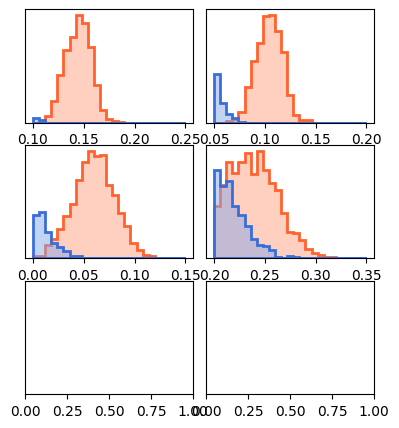

In [19]:
fig = plt.figure(figsize=(4.5,5.0))
gs = fig.add_gridspec(
    nrows=3, ncols=2, hspace=0.2, wspace=0.08, 
)
ax = [
    fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1]), 
    fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1]), 
    fig.add_subplot(gs[2,0]), fig.add_subplot(gs[2,1]), 
    ]

hist_kwargs_A = dict(
    bins=25, histtype='stepfilled', fc=env_colors_m_A[1], ec=color_m_A, lw=2, bottom=0
)

hist_kwargs_B = hist_kwargs_A.copy()
hist_kwargs_B['fc'] = env_colors_m_B[1]
hist_kwargs_B['ec'] = color_m_B

hist_range = [0.1,0.25]
ax[0].hist(abs_abund_A['C/H'][:,0], range=hist_range, **hist_kwargs_A)
ax[0].hist(abs_abund_B['C/H'][:,0], range=hist_range, **hist_kwargs_B)

hist_range = [0.05,0.2]
ax[1].hist(abs_abund_A['O/H'][:,0], range=hist_range, **hist_kwargs_A)
ax[1].hist(abs_abund_B['O/H'][:,0], range=hist_range, **hist_kwargs_B)


hist_range = [0.0,0.15]
ax[2].hist(abs_abund_A['F/H'][:,0], range=hist_range, **hist_kwargs_A)
ax[2].hist(abs_abund_B['F/H'][:,0], range=hist_range, **hist_kwargs_B)

hist_range = [0.2,0.35]
ax[3].hist(abs_abund_A['S/H'][:,0], range=hist_range, **hist_kwargs_A)
ax[3].hist(abs_abund_B['S/H'][:,0], range=hist_range, **hist_kwargs_B)


for ax_i in ax:
    ax_i.set_yticks([])
    #ax_i.annotate(
    #    label_i, xy=(0.05,0.95), ha='left', va='top', xycoords='axes fraction', fontsize=13, 
    #    fontweight='bold', path_effects=[pe.withStroke(linewidth=3, foreground='w', alpha=0.9)],
    #    )
    
plt.show()